In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd

# PGIM effective rent data

In [3]:
#PGIM data

df = pd.read_excel('/Users/yilingwu/Desktop/Data Science Clinic/2023-spring-pgim/data/Effective Rent By ZipCode - RealPage.xlsx')
df = (df.set_index(['Geography Name', 'Geography Type', 'Market Name', 'Unique ID',
           'Metric Type', 'Metric Name', 'Category', 'Niche']).stack().reset_index()
     .rename(columns={'level_8' : 'time_period', 0 : 'e_rent'})
    )

In [4]:
pgim_sf = df[df['Market Name'].str.upper().str.contains('SAN FRAN').fillna(False)]
pgim_sf = pgim_sf[['Unique ID','time_period','e_rent']]
pgim_sf = pgim_sf.rename(columns = {'Unique ID': 'Zip Code','time_period':'y_dt'}).reset_index()

In [5]:
quarter_dict = {'Q1': '-01-01', 'Q2': '-04-01', 'Q3': '-07-01', 'Q4': '-10-01'}
pgim_sf['y_dt'] = pgim_sf['y_dt'].apply(lambda x: x[1:5] + quarter_dict[x[5:]])
pgim_sf['y_dt'] = pd.to_datetime(pgim_sf['y_dt'])

In [6]:
pgim_sf = pgim_sf.drop(columns = 'index')

In [7]:
mask = (pgim_sf['y_dt'].dt.year >= 2011) & (pgim_sf['y_dt'].dt.year <= 2018)
df_filtered = pgim_sf.loc[mask]

In [8]:
df_filtered = df_filtered.reset_index(drop = True)

In [9]:
df_filtered

,Zip Code,y_dt,e_rent
0,94108,2011-01-01,1699.0
1,94108,2011-04-01,1714.0
2,94108,2011-07-01,1787.0
3,94108,2011-10-01,1864.0
4,94108,2012-01-01,2001.0
...,...,...,...
1335,94925,2017-10-01,4048.0
1336,94925,2018-01-01,4099.0
1337,94925,2018-04-01,3859.0
1338,94925,2018-07-01,3799.0


# Population + Housing data from ACS

In [10]:
acs = pd.read_csv('/Users/yilingwu/Desktop/SF dataset/Q_SF_ACS_2011-2018.csv')

In [30]:
acs

,y_dt,Zip Code,Quarterly Total Population,Quarterly Bachelor or higher,Quarterly Total Housing,Quarterly Owner-occupied housing units,Quarterly Renter-occupied housing units,Quarterly Median Household Income (USD),Quarterly Percentage of Rent,Bachelor or higher Precentage
0,2011-01-01,94002,25797,10292,10936,10352,584,100125,0.053402,0.398961
1,2011-04-01,94002,25883,10396,10935,10358,577,100746,0.052766,0.401654
2,2011-07-01,94002,25969,10501,10935,10364,571,101368,0.052218,0.404367
3,2011-10-01,94002,26055,10605,10935,10370,565,101989,0.051669,0.407024
4,2012-01-01,94002,26141,10710,10935,10376,559,102611,0.051120,0.409701
...,...,...,...,...,...,...,...,...,...,...
1819,2017-10-01,94965,11360,6005,6471,5884,586,103054,0.090558,0.528609
1820,2018-01-01,94965,11408,6074,6459,5905,554,103424,0.085772,0.532433
1821,2018-04-01,94965,11404,6041,6435,5916,519,103915,0.080653,0.529726
1822,2018-07-01,94965,11401,6009,6411,5927,484,104407,0.075495,0.527059


In [38]:
acs_pop = acs[['y_dt','Zip Code','Quarterly Total Population','Quarterly Total Housing']]
acs_pop['y_dt'] = pd.to_datetime(acs_pop['y_dt'])

/var/folders/kz/dhtdp71n1q98lc7x715t7c0h0000gp/T/ipykernel_79979/681653457.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [32]:
acs_pop

,y_dt,Zip Code,Quarterly Total Population,Quarterly Total Housing
0,2011-01-01,94002,25797,10936
1,2011-04-01,94002,25883,10935
2,2011-07-01,94002,25969,10935
3,2011-10-01,94002,26055,10935
4,2012-01-01,94002,26141,10935
...,...,...,...,...
1819,2017-10-01,94965,11360,6471
1820,2018-01-01,94965,11408,6459
1821,2018-04-01,94965,11404,6435
1822,2018-07-01,94965,11401,6411


In [39]:
merge_data = pd.merge(acs_pop,df_filtered, on = ['y_dt','Zip Code'], how = 'inner')

In [34]:
merge_data

,y_dt,Zip Code,Quarterly Total Population,Quarterly Total Housing,e_rent
0,2011-01-01,94002,25797,10936,1491.0
1,2011-04-01,94002,25883,10935,1603.0
2,2011-07-01,94002,25969,10935,1658.0
3,2011-10-01,94002,26055,10935,1698.0
4,2012-01-01,94002,26141,10935,1701.0
...,...,...,...,...,...
1335,2017-10-01,94965,11360,6471,3084.0
1336,2018-01-01,94965,11408,6459,3121.0
1337,2018-04-01,94965,11404,6435,3135.0
1338,2018-07-01,94965,11401,6411,3284.0


**The below method is wrong!!!**

In [40]:
merge_data['Delta Effective Rent'] = merge_data.groupby('Zip Code')['e_rent'].diff(periods=6)
merge_data['Delta Population'] = merge_data.groupby('Zip Code')['Quarterly Total Population'].diff(periods=4)
merge_data['Delta Housing'] = merge_data.groupby('Zip Code')['Quarterly Total Housing'].diff(periods=4)

In [41]:
merge_data

,y_dt,Zip Code,Quarterly Total Population,Quarterly Total Housing,e_rent,Delta Effective Rent,Delta Population,Delta Housing
0,2011-01-01,94002,25797,10936,1491.0,NaN,NaN,NaN
1,2011-04-01,94002,25883,10935,1603.0,NaN,NaN,NaN
2,2011-07-01,94002,25969,10935,1658.0,NaN,NaN,NaN
3,2011-10-01,94002,26055,10935,1698.0,NaN,NaN,NaN
4,2012-01-01,94002,26141,10935,1701.0,NaN,344.0,-1.0
...,...,...,...,...,...,...,...,...
1335,2017-10-01,94965,11360,6471,3084.0,-49.0,141.0,-50.0
1336,2018-01-01,94965,11408,6459,3121.0,177.0,191.0,-48.0
1337,2018-04-01,94965,11404,6435,3135.0,143.0,140.0,-60.0
1338,2018-07-01,94965,11401,6411,3284.0,273.0,89.0,-72.0


In [37]:
px.line(merge_data, x='y_dt', y='Delta Population', color = 'Zip Code',
              title='Quarterly Total Population and e_rent over Time')

In [22]:
px.line(merge_data, x='y_dt', y='Delta Effective Rent', color = 'Zip Code',
              title='Quarterly Total Population and e_rent over Time')

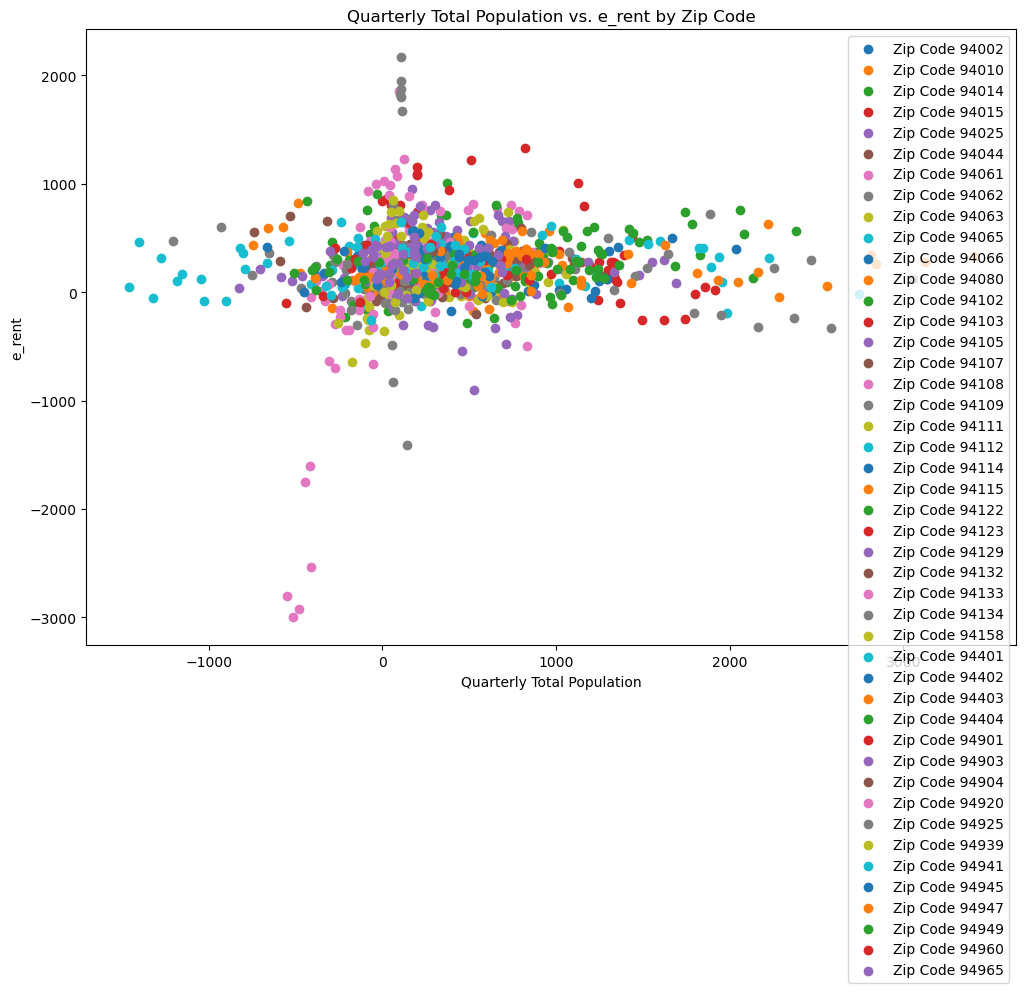

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
for zip_code in merge_data['Zip Code'].unique():
    df = merge_data[merge_data['Zip Code'] == zip_code]
    ax.scatter(df['Delta Population'], df['Delta Effective Rent'], label=f'Zip Code {zip_code}')
ax.legend()
ax.set_xlabel('Quarterly Total Population')
ax.set_ylabel('e_rent')
ax.set_title('Quarterly Total Population vs. e_rent by Zip Code')
plt.show()

In [42]:
merge_data2 = merge_data.dropna()

In [43]:
X = merge_data2[['Delta Population','Delta Housing']]
y = merge_data2['Delta Effective Rent']

In [44]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     Delta Effective Rent   R-squared:                       0.012
Model:                              OLS   Adj. R-squared:                  0.011
Method:                   Least Squares   F-statistic:                     6.697
Date:                  Tue, 18 Apr 2023   Prob (F-statistic):            0.00129
Time:                          20:36:58   Log-Likelihood:                -7838.8
No. Observations:                  1073   AIC:                         1.568e+04
Df Residuals:                      1070   BIC:                         1.570e+04
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              2

If the Quarterly Total Population increased by 10%, we would expect the effective rent to decrease by approximately 1.67%.